In [2]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt

import tensorflow as tf
import re

#Si vous n'avez pas de GPU ou que vous ne voulez pas l'utiliser, commentez les 2 lignes suivantes
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras

LE = LabelEncoder()

from PIL import Image
# from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
os.environ['TF_DETERMINISTIC_OPS'] = '1' #  c'est la ligne la plus importante
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUDA_VISIBLE_DEVICES'] = '' #  c'est facultatif
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
train_mat = loadmat('./train_data.mat')
test_mat = loadmat('./test_data.mat')
print(train_mat.keys())
print(test_mat.keys())

dict_keys(['train_info', 'train_fg_data', 'train_data'])
dict_keys(['test_info', 'test_fg_data', 'test_data'])


In [29]:
train_mat_train_info = pd.DataFrame(train_mat.get('train_info'))
test_mat_train_info = pd.DataFrame(train_mat.get('test_fg_data'))

In [26]:
train_mat_train_info

,file_list,annotation_list,labels,fg_ids
0,[n02085620-Chihuahua/n02085620_5927.jpg],[n02085620-Chihuahua/n02085620_5927],[1],[histograms_spm/n02085620-Chihuahua/n02085620_...
1,[n02085620-Chihuahua/n02085620_4441.jpg],[n02085620-Chihuahua/n02085620_4441],[1],[histograms_spm/n02085620-Chihuahua/n02085620_...
2,[n02085620-Chihuahua/n02085620_1502.jpg],[n02085620-Chihuahua/n02085620_1502],[1],[histograms_spm/n02085620-Chihuahua/n02085620_...
3,[n02085620-Chihuahua/n02085620_1916.jpg],[n02085620-Chihuahua/n02085620_1916],[1],[histograms_spm/n02085620-Chihuahua/n02085620_...
4,[n02085620-Chihuahua/n02085620_13151.jpg],[n02085620-Chihuahua/n02085620_13151],[1],[histograms_spm/n02085620-Chihuahua/n02085620_...
...,...,...,...,...
11995,[n02116738-African_hunting_dog/n02116738_10614...,[n02116738-African_hunting_dog/n02116738_10614],[120],[histograms_spm/n02116738-African_hunting_dog/...
11996,[n02116738-African_hunting_dog/n02116738_9282....,[n02116738-African_hunting_dog/n02116738_9282],[120],[histograms_spm/n02116738-African_hunting_dog/...
11997,[n02116738-African_hunting_dog/n02116738_6754....,[n02116738-African_hunting_dog/n02116738_6754],[120],[histograms_spm/n02116738-African_hunting_dog/...
11998,[n02116738-African_hunting_dog/n02116738_9333....,[n02116738-African_hunting_dog/n02116738_9333],[120],[histograms_spm/n02116738-African_hunting_dog/...


In [30]:
test_mat_train_info

""


In [28]:
for i in train_mat_train_info.columns:
    column = np.array(train_mat_train_info[i].values.tolist())
    train_mat_train_info[i] = column
    
for i in test_mat_train_info.columns:
    column = np.array(test_mat_train_info[i].values.tolist())
    test_mat_train_info[i] = column

In [21]:
print(train_mat_train_info.columns)
print(test_mat_train_info.columns)

Index(['file_list', 'annotation_list', 'labels', 'fg_ids'], dtype='object')
Index([], dtype='object')


In [18]:
labels_distinct = train_mat_train_info.drop_duplicates(['labels'])
class_names = []
for i in labels_distinct:
    dog_race = re.match(r'^\w+-(.+)\/\w+$', i).group(1)
    class_names.append(dog_race)
    print(dog_race)

AttributeError: 'NoneType' object has no attribute 'group'

In [137]:
class_names

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black-and-tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_wh

In [15]:
train_mat_train_info = train_mat_train_info.drop_duplicates(['labels'])

TypeError: unhashable type: 'list'

In [150]:
def load_img(i):
    img = "./dogs-dataset-images/" + train_mat_train_info.file_list[i]
    img = tf.keras.preprocessing.image.load_img(img, target_size=(50,50))
    return img

def load_label(i):
    label_index = train_mat_train_info.labels[i]
    label_race = class_names[label_index-1]
    
    return "{} [{}]".format(label_race, label_index)

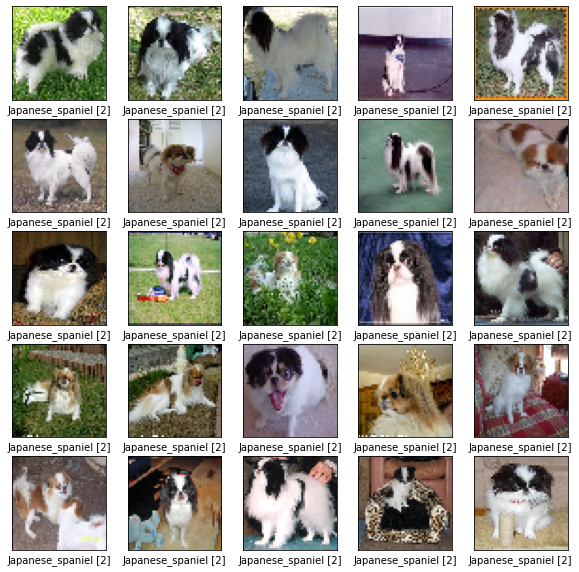

In [151]:
plt.figure(figsize=(10,10))

for i in range(100, 125):
    plt.subplot(5,5,i-100+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(load_img(i))
    plt.xlabel(load_label(i))
    
plt.show()